In [1]:
!nvidia-smi

Fri Apr  1 14:56:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:3B:00.0 Off |                    0 |
| N/A   20C    P8     9W / 250W |      0MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [2]:
#!git clone https://github.com/jcpeterson/cifar-10h
%cd cifar-10h

/data/user-data/sa25729/cifar-10h


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='CIFAR-10H Training')
parser.add_argument('--lr', default=5e-2, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=1024, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=100, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=10, help='number classes')
args = parser.parse_args(args=[])

In [4]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets, ad) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

In [5]:
from PIL import Image
import numpy as np
import torchvision

class CIFAR10H(torchvision.datasets.CIFAR10):

    def __init__(self, root,  rand_number=0, train=False, transform=None, target_transform=None,
                 download=False):
        super(CIFAR10H, self).__init__(root, train, transform, target_transform, download) 
        self.transform = transform
        self.target_transform = target_transform
        self.ad = np.load(os.path.join(root,'cifar10h-probs.npy'))

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        ad = self.ad[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, ad

class CELossWithLS(torch.nn.Module):
    
    def __init__(self, classes= args.num_classes, smoothing=0.0, ignore_index=-1):
        super(CELossWithLS, self).__init__()
        self.smoothing = smoothing
        self.complement = 1.0 - smoothing
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        with torch.no_grad():
#             new_smoothing  = self.smoothing - conf_score/10
#             new_complement = 1 - new_smoothing
            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement + self.smoothing / self.cls
        
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1).mean()


In [ ]:
seed_everything()
conf_score = torch.tensor([0.8265, 0.8410, 0.7920, 0.7833, 0.7851, 0.8231, 0.8496, 0.8212, 0.8126,
        0.8997])
conf_score = conf_score.to(device)
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])

train_dataset = CIFAR10H(root='./data', train=False, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
print('train samples:',len(train_dataset), 'test samples:',len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

# model = models.resnet34(pretrained=True).to(device)
# model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, args.num_classes)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
#criterion = nn.CrossEntropyLoss()
criterion = CELossWithLS().to(device)

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    if epoch is not 0 and epoch < 100 and epoch % 30 == 0:
        for param in optimizer.param_groups:
            param['lr'] = param['lr'] / 10
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_densenet_cifar10h_5e-2.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Files already downloaded and verified
Files already downloaded and verified
train samples: 10000 test samples: 50000
epoch: 0  acc: 0.4918  best epoch: 0  best acc: 0.4918
epoch: 1  acc: 0.5892  best epoch: 1  best acc: 0.5892
epoch: 2  acc: 0.6487  best epoch: 2  best acc: 0.6487
epoch: 3  acc: 0.7013  best epoch: 3  best acc: 0.7013
epoch: 4  acc: 0.7336  best epoch: 4  best acc: 0.7336
epoch: 5  acc: 0.7666  best epoch: 5  best acc: 0.7666
epoch: 6  acc: 0.7645  best epoch: 5  best acc: 0.7666
epoch: 7  acc: 0.7742  best epoch: 7  best acc: 0.7742
epoch: 8  acc: 0.7390  best epoch: 7  best acc: 0.7742
epoch: 9  acc: 0.7749  best epoch: 9  best acc: 0.7749
epoch: 10  acc: 0.7829  best epoch: 10  best acc: 0.7829
epoch: 11  acc: 0.7740  best epoch: 10  best acc: 0.7829
epoch: 12  acc: 0.7689  best epoch: 10  best acc: 0.7829
epoch: 13  acc: 0.7774  best epoch: 10  best acc: 0.7829
epoch: 14  acc: 0.7779  best epoch: 10  best acc: 0.7829
epoch: 15  acc: 0.7753  best epoch: 10  best acc

CCA: get confidence score

In [5]:
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])

train_dataset = CIFAR10H(root='./data', train=False, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
print('train samples:',len(train_dataset), 'test samples:',len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

model = models.resnet34(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
#criterion = nn.CrossEntropyLoss()
criterion = CELossWithLS().to(device)
model.load_state_dict(torch.load('best_model_cifar10h.pth_LS_lr.tar'))

Files already downloaded and verified
Files already downloaded and verified
train samples: 10000 test samples: 50000


<All keys matched successfully>

Conf_score from Trainset

In [6]:
model.load_state_dict(torch.load('best_model_cifar10h.pth_LS_lr.tar'))
def get_conf_freq (model, dataloader):
    model.eval()
    conf_score = torch.zeros([10]).to(device)
    count = torch.zeros([10]).to(device)
    with torch.no_grad():
        for batch_idx, (inputs, targets, ad) in enumerate(dataloader):
            inputs, targets, ad = inputs.to(device), targets.to(device), ad.to(device)
            outputs = model(inputs)
            softmaxes = F.softmax(outputs, dim=1)

            for i in range (len(targets)):
                confidence = softmaxes[i][targets[i]]
                conf_score[targets[i]] += confidence
                count[targets[i]] += 1
            conf_avg = conf_score/count
    return conf_avg

conf_score = get_conf_freq(model, train_loader)
conf_score


tensor([0.8525, 0.8496, 0.8505, 0.8509, 0.8511, 0.8459, 0.8480, 0.8501, 0.8526,
        0.8531], device='cuda:0')

Conf_score from Testset

In [8]:
model.load_state_dict(torch.load('best_model_cifar10h1.pth.tar'))
def get_conf_freq (model, dataloader):
    model.eval()
    conf_score = torch.zeros([10]).to(device)
    count = torch.zeros([10]).to(device)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            softmaxes = F.softmax(outputs, dim=1)

            for i in range (len(targets)):
                confidence = softmaxes[i][targets[i]]
                conf_score[targets[i]] += confidence
                count[targets[i]] += 1
            conf_avg = conf_score/count
    return conf_avg

conf_score_test = get_conf_freq(model, test_loader)
conf_score_test

tensor([0.8188, 0.8767, 0.7144, 0.6143, 0.7532, 0.6945, 0.8224, 0.8255, 0.8705,
        0.8474], device='cuda:0')

ECE

In [7]:
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])

train_dataset = CIFAR10H(root='./data', train=False, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
print('train samples:',len(train_dataset), 'test samples:',len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, args.num_classes)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('best_model_densenet_cifar10h.pth.tar'))
accuracy = test(model, test_loader)
accuracy

Files already downloaded and verified
Files already downloaded and verified
train samples: 10000 test samples: 50000


0.7761

In [9]:
class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
    
def evaluation(model, testloader):
    model.eval()
    correct = 0
    total = 0
    logits_list, labels_list = [], [] 
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            logits_list.append(outputs)
            labels_list.append(targets)
            
        logits_all = torch.cat(logits_list).cuda()
        labels_all = torch.cat(labels_list).cuda()
    return correct / total, logits_all, labels_all

ece_criterion = _ECELoss().to(device)
accuracy,logits_all,labels_all = evaluation(model, test_loader)
logits_all = logits_all.view(-1,args.num_classes)
labels_all = labels_all.view(-1)
temperature_ece = ece_criterion(logits_all, labels_all).item()
temperature_ece

0.10267047584056854

Reliability Diagram

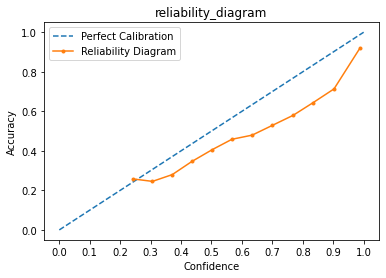

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def ece_eval(preds, targets, n_bins=15, bg_cls = -1):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm


def get_reliability_diagram(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10, fig=2):
    plt.figure(fig)
    plt.plot([0, 1], [0, 1], linestyle='--',label = 'Perfect Calibration')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    plt.title('{}'.format(fig))
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_reliability_diag_{}.png'.format(fig),dpi=300)
    
logits_all =F.softmax(logits_all, dim=1).detach().cpu().numpy()
labels_all =labels_all.detach().cpu().numpy()
ece, acc, conf, Bm = ece_eval(logits_all, labels_all)
get_reliability_diagram(conf, acc, legend='Reliability Diagram', fig='reliability_diagram')

In [11]:
print(conf, type(conf))
print(acc,type(acc))

[0.         0.         0.         0.24116675 0.30610303 0.37126415
 0.43542159 0.50298798 0.56711433 0.63356994 0.70047104 0.76833386
 0.83449784 0.9026194  0.98829782] <class 'numpy.ndarray'>
[0.         0.         0.         0.25806452 0.24553571 0.27986348
 0.34611697 0.40648096 0.45846314 0.47945892 0.52919197 0.57976336
 0.64442916 0.71337017 0.92094706] <class 'numpy.ndarray'>
